In [1]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=bdf71ceef0fe3599e535579adba28ea1f41360d74c70f55865431f1133d0a4d8
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [16]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, desc
import seaborn as sns
import numpy as np
import pandas as pd


In [3]:
spark = SparkSession.builder.appName("Movie_Recommendation_System").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Music_recommendation_System>

In [5]:
df = spark.read.csv("./ratings.csv", inferSchema=True,header=True)

In [6]:
movie_data =spark.read.csv("./movies_metadata.csv", inferSchema=True,header=True)

In [8]:
movie_data.show(4)

+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------+--------------------+-----------------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|   original_title|            overview|popularity|         poster_path|production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|  status|             tagline|               title|   video|        vote_average|       vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+-----------------+--------------------+----------+--------------

In [9]:
df.show(4)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
+------+-------+------+----------+
only showing top 4 rows



In [ ]:
# Kullanıcıların puan aralıklarındaki film sayıları

In [10]:
groupby_df=df.groupBy("movieId")

In [11]:
groupby_sorted_df=groupby_df.agg({"rating":"mean"}).orderBy(desc("avg(rating)"))
popular=groupby_sorted_df.groupBy("avg(rating)").count()
popular=popular.orderBy(desc("avg(rating)"))
popular.show(10)
groupby_sorted_df.show(10)

+-----------------+-----+
|      avg(rating)|count|
+-----------------+-----+
|              5.0|  148|
|4.833333333333333|    2|
|             4.75|    8|
|              4.7|    1|
|4.666666666666667|    9|
|            4.625|    2|
|              4.6|    1|
|4.590909090909091|    1|
|4.576923076923077|    1|
|4.571428571428571|    3|
+-----------------+-----+
only showing top 10 rows

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
|  44193|        5.0|
|   4209|        5.0|
|   1574|        5.0|
|  60766|        5.0|
|   2697|        5.0|
|   5155|        5.0|
|   3795|        5.0|
| 101362|        5.0|
| 135861|        5.0|
|   7647|        5.0|
+-------+-----------+
only showing top 10 rows



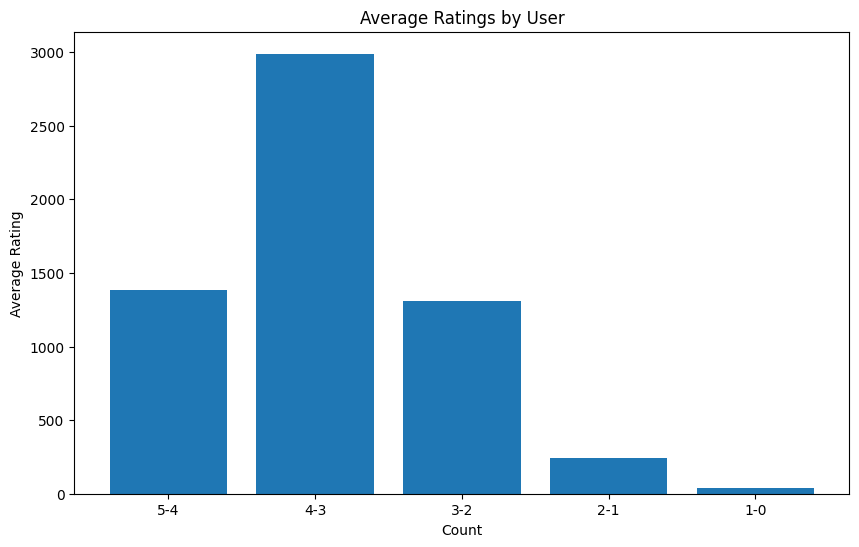

In [12]:
data = popular.collect()

dort_bes = popular.select("avg(rating)", "count").filter((col("avg(rating)") <= 5.0) & (col("avg(rating)") >= 4.0))
dort_bes = dort_bes.agg({"count": "sum"}).collect()[0][0]
uc_dort = popular.select("avg(rating)", "count").filter((col("avg(rating)") < 4.0) & (col("avg(rating)") >= 3.0))
uc_dort = uc_dort.agg({"count": "sum"}).collect()[0][0]
iki_uc = popular.select("avg(rating)", "count").filter((col("avg(rating)") < 3.0) & (col("avg(rating)") >= 2.0))
iki_uc = iki_uc.agg({"count": "sum"}).collect()[0][0]
bir_iki = popular.select("avg(rating)", "count").filter((col("avg(rating)") < 2.0) & (col("avg(rating)") >= 1.0))
bir_iki = bir_iki.agg({"count": "sum"}).collect()[0][0]
sıfır_bir = popular.select("avg(rating)", "count").filter((col("avg(rating)") < 1.0) & (col("avg(rating)") >= 0))
sıfır_bir = sıfır_bir.agg({"count": "sum"}).collect()[0][0]
sayilar=[dort_bes,uc_dort,iki_uc,bir_iki,sıfır_bir]
columns = ["5-4","4-3","3-2","2-1","1-0"]



plt.figure(figsize=(10, 6))
plt.bar(columns, sayilar)
plt.xlabel("Count")
plt.ylabel("Average Rating")
plt.title("Average Ratings by User")
plt.show()

In [13]:
total_movie_rows = movie_data.count()
total_ratings_rows = df.count()
print("total_movie_rows = ",total_movie_rows)
print("total_ratings_rows = ",total_ratings_rows)

total_movie_rows =  2531
total_ratings_rows =  43014


In [7]:
train,test = df.randomSplit([0.7,0.3])

In [ ]:
recommender = ALS(userCol= 'userId' , ratingCol="rating", itemCol="movieId", )
recommender = recommender.fit(train)

In [ ]:
preds = recommender.transform(test)

In [ ]:
preds.show(10)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|   5577|   5.0|1425941397|  4.142693|
|     1|  54503|   3.5|1425941313| 4.1475067|
|     1|  58559|   4.0|1425942007|  4.362197|
|     1|  73017|   5.0|1425942699| 4.1497593|
|     1|  81834|   5.0|1425942133| 4.1958966|
|     1|  98809|   0.5|1425942640| 3.7800636|
|     2|      5|   3.0| 867039249| 2.3916283|
|     2|     32|   2.0| 867039166| 3.7248333|
|     2|     79|   4.0| 867039325| 2.8598292|
|     2|    260|   4.0| 867039249|  4.025438|
+------+-------+------+----------+----------+
only showing top 10 rows



In [ ]:
preds = preds.dropna()

In [ ]:
evaluator = RegressionEvaluator(predictionCol="prediction", metricName="mse",labelCol = "rating")
mse = evaluator.evaluate(preds)
print(mse)

0.6793202791388973


In [ ]:
evaluator = RegressionEvaluator(predictionCol="prediction", metricName="rmse",labelCol = "rating")
rmse = evaluator.evaluate(preds)

In [ ]:
print(rmse)

0.8242088807692485


In [8]:
def create_model(params,train,test):
    rmse = None
    mse = None
    preds = None
    try:
        rank,iter_,lambda_ = params
        recommender = ALS(rank=rank, maxIter=iter_, regParam=lambda_, seed=seed,userCol= 'userId' , ratingCol="rating", itemCol="movieId",)
        recommender = recommender.fit(train)
        #predictions
        preds = recommender.transform(test)
        preds = preds.dropna()
        #Calculating rmse and mse we use default values predCol = prediction and metricName = rmse
        evaluator = RegressionEvaluator(predictionCol="prediction", metricName="mse",labelCol = "rating")
        mse = evaluator.evaluate(preds)

        evaluator = RegressionEvaluator(predictionCol="prediction", metricName="rmse",labelCol = "rating")
        rmse = evaluator.evaluate(preds)

    except Exception as e:
        print("UPPSSSS")
        print(e)

    return (rank,iter_,lambda_,rmse,mse,preds)

In [9]:
seed = 5078
ranks = [10,50,200]
iterations = [10, 50, 200]
lambdas = [0.01, 0.1]

In [10]:
results = []
result = create_model((10,10,0.01),train,test)
results.append(result)

result =  create_model((10,10,0.1),train,test)
results.append(result)

In [ ]:
print(results)

[(10, 10, 0.01, 0.8562657045486239, 0.7331909567861514, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]), (10, 10, 0.1, 0.8208484038375777, 0.673792102082699, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float])]


In [11]:
result = create_model((10,15,0.01),train,test)
results.append(result)

result =  create_model((10,15,0.1),train,test)
results.append(result)

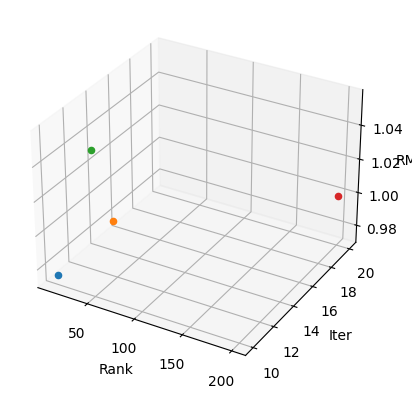

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for i in range(len(results)):
    if results[i][3] != None and results[i][2]==0.01:
        ax.scatter(results[i][0], results[i][1], results[i][3], marker="o")

ax.set_xlabel('Rank')
ax.set_ylabel('Iter')
ax.set_zlabel('RMSE')

plt.show()

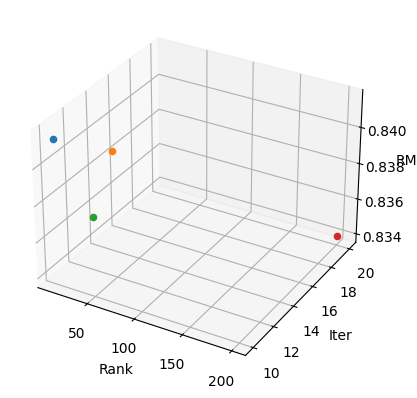

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for i in range(len(results)):
    if results[i][3] != None and results[i][2]==0.1:
        ax.scatter(results[i][0], results[i][1], results[i][3], marker="o")

ax.set_xlabel('Rank')
ax.set_ylabel('Iter')
ax.set_zlabel('RMSE')

plt.show()

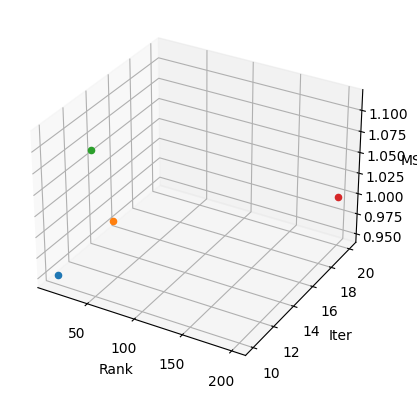

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for i in range(len(results)):
    if results[i][4] != None and results[i][2]==0.01:
        ax.scatter(results[i][0], results[i][1], results[i][4], marker="o")

ax.set_xlabel('Rank')
ax.set_ylabel('Iter')
ax.set_zlabel('MSE')

plt.show()

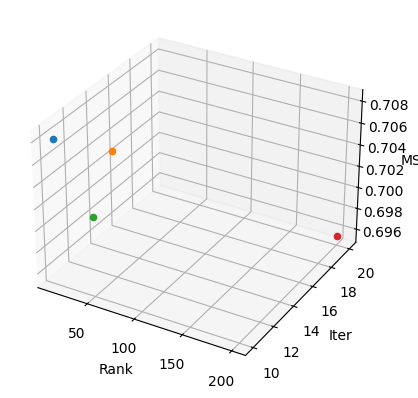

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for i in range(len(results)):
    if results[i][4] != None and results[i][2]==0.1:
        ax.scatter(results[i][0], results[i][1], results[i][4], marker="o")

ax.set_xlabel('Rank')
ax.set_ylabel('Iter')
ax.set_zlabel('MSE')

plt.show()

In [12]:
result = create_model((50,10,0.01),train,test)
results.append(result)

result =  create_model((50,10,0.1),train,test)
results.append(result)

In [15]:
result = create_model((200,20,0.01),train,test)
results.append(result)

result =  create_model((200,20,0.1),train,test)
results.append(result)

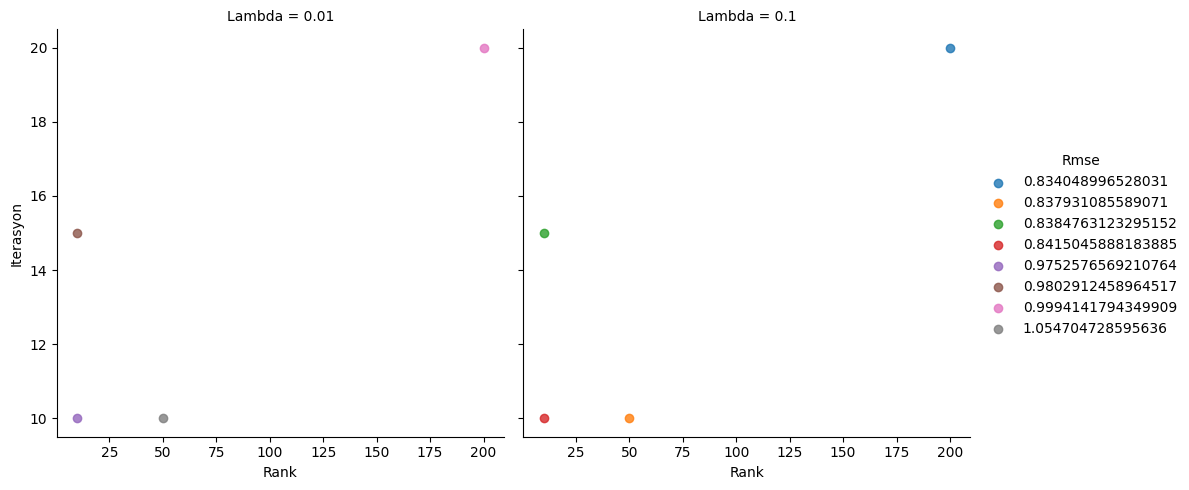

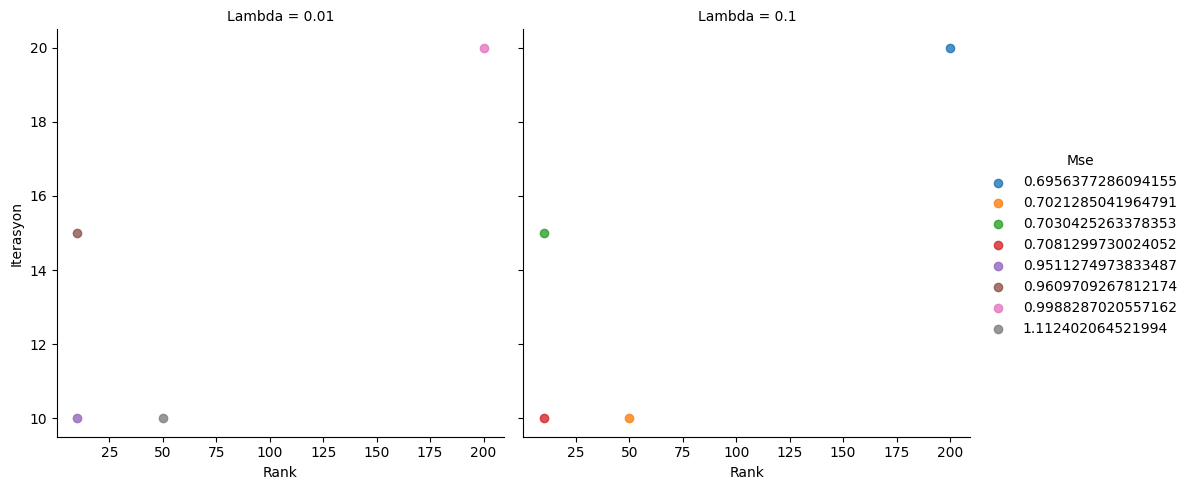

In [17]:
Lambda = []
Iterasyon = []
Rank = []
Mse = []
Rmse = []
for i in results:
    Rank.append(i[0])
    Iterasyon.append(i[1])
    Lambda.append(i[2])
    Rmse.append(i[3])
    Mse.append(i[4])


dataFrame1 = pd.DataFrame({'Rank': Rank, 'Iterasyon': Iterasyon, 'Mse': Mse, 'Lambda': Lambda})
dataFrame2 = pd.DataFrame({'Iterasyon': Iterasyon, 'Rank': Rank, 'Rmse': Rmse, 'Lambda': Lambda})


sns.lmplot(x="Rank", y="Iterasyon", hue="Rmse", col="Lambda", data=dataFrame2)
sns.lmplot(x="Rank", y="Iterasyon", hue="Mse", col="Lambda", data=dataFrame1)

In [18]:
print(results)

[(10, 10, 0.01, 0.9752576569210764, 0.9511274973833487, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]), (10, 10, 0.1, 0.8415045888183885, 0.7081299730024052, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]), (10, 15, 0.01, 0.9802912458964517, 0.9609709267812174, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]), (10, 15, 0.1, 0.8384763123295152, 0.7030425263378353, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]), (50, 10, 0.01, 1.054704728595636, 1.112402064521994, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]), (50, 10, 0.1, 0.837931085589071, 0.7021285041964791, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]), (200, 20, 0.01, 0.9994141794349909, 0.9988287020557162, DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction

In [ ]:
result = create_model((10,50,0.01),train,test)
results.append(result)

result =  create_model((10,50,0.1),train,test)
results.append(result)

In [19]:
# ALS model and Cosine_Similarity (200, 20, 0.1,) best model params

In [23]:
als_best = ALS(rank = 200,maxIter=20,regParam=0.1,seed=seed,userCol= 'userId' , ratingCol="rating", itemCol="movieId")
best_als_model=als_best.fit(train)

movie_factors = best_als_model.itemFactors
movie_factors.show()


+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.15631992, -0....|
| 20|[0.1305223, -0.42...|
| 30|[0.0641885, -0.08...|
| 40|[0.025134357, -0....|
| 50|[-0.21635891, 0.3...|
| 60|[0.41850582, -0.2...|
| 70|[-0.10571558, -0....|
| 80|[-0.014222055, 0....|
| 90|[0.21331997, -0.2...|
|100|[-0.6314476, -9.1...|
|110|[-0.57416135, -0....|
|120|[0.22761054, -0.5...|
|140|[-0.3776482, -0.5...|
|150|[-0.115287915, 0....|
|160|[-0.08104704, -0....|
|170|[-0.25130683, -0....|
|180|[-0.3773916, 0.16...|
|190|[0.22726648, 0.30...|
|200|[0.12583381, -0.4...|
|210|[-0.08126328, -0....|
+---+--------------------+
only showing top 20 rows



In [24]:
specific_movie_id = 120
specific_movie_factors = best_als_model.itemFactors.filter(col("id") == specific_movie_id).select("features").collect()[0]["features"]

# Tüm kullanıcıların öğrenilmiş kullanıcı faktörlerini al
user_factors = best_als_model.userFactors.select("id", "features").collect()

# Cosine similarity hesapla
similarities = [(user_id, Vectors.dense(user_factors[i]["features"]).dot(Vectors.dense(specific_movie_factors)))
                for i, user_id in enumerate([row["id"] for row in user_factors])]

# Benzerlik skorlarına göre sırala
similarities.sort(key=lambda x: x[1], reverse=True)

# En çok benzerlik gösteren ilk 10 kullanıcıyı seç
top_users = similarities[:10]

# Sonuçları yazdır
movie_title = movie_data.filter(movie_data["id"] == specific_movie_id).select("original_title").first()["original_title"]
print(f"{movie_title} filmi için en çok benzerlik gösteren 10 kullanıcı:")
for user_id, similarity_score in top_users:
    print(f"Kullanıcı ID: {user_id}, Benzerlik Skoru: {similarity_score}")

The Lord of the Rings: The Fellowship of the Ring filmi için en çok benzerlik gösteren 10 kullanıcı:
Kullanıcı ID: 4240, Benzerlik Skoru: 3.323905543903538
Kullanıcı ID: 3852, Benzerlik Skoru: 3.092528787717831
Kullanıcı ID: 4876, Benzerlik Skoru: 3.0745254719773563
Kullanıcı ID: 486, Benzerlik Skoru: 3.0695923350308445
Kullanıcı ID: 4446, Benzerlik Skoru: 3.018072526101286
Kullanıcı ID: 1310, Benzerlik Skoru: 2.975341958970409
Kullanıcı ID: 270, Benzerlik Skoru: 2.972230907082324
Kullanıcı ID: 3381, Benzerlik Skoru: 2.9411911494291845
Kullanıcı ID: 5463, Benzerlik Skoru: 2.937673528362482
Kullanıcı ID: 3639, Benzerlik Skoru: 2.929956312274645


In [22]:
import socket

hostname = socket.gethostname()
local_ip = socket.gethostbyname(hostname)
try:
    external_ip = socket.gethostbyname(socket.gethostname())
except socket.gaierror:
    external_ip = "External IP not available"

# Display the information
print(f"Hostname: {hostname}")
print(f"Local IP Address: {local_ip}")
print(f"External IP Address: {external_ip}")

Hostname: 3ca6fbb02985
Local IP Address: 172.28.0.12
External IP Address: 172.28.0.12
